Question: Can we integrate a RAG Pipeline?
Answer: Yes we can!

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings=GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm=ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hii").content

'Hello there! How are you doing today?'

In [2]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_strings=[doc.page_content for doc in new_docs]

db=FAISS.from_documents(new_docs,embeddings)
reteriver=db.as_retriever(search_kwargs={"k":3})

query="what is meta llama?"
docs=reteriver.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

C:\Users\ayush\AppData\Local\Temp\ipykernel_10724\3250290832.py:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs=reteriver.get_relevant_documents(query)


{'source': 'data\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data\\llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': 'data\\llama3.txt'}
page_content='available as a foundation model.[8] Starting with Llama 2, Meta AI started releasing instruction' metadata={'source': 'data\\llama3.txt'}


In [4]:
def function_1(AgentState):
    message=AgentState["message"]

    question=message[-1]

    complete_prompt="Your task is to provide the brief answer based on the user query Don't include too much reasoning . Following is the user:" + question

    response=llm.invoke(complete_prompt)

    ## Appending LLm call response to the Agentstate
    AgentState["message"].append(response.content)

    return AgentState

In [5]:
def function_2(AgentState):
    message=AgentState['message']
    ## Fetching the user Question
    question=message[0]
    template=""" Answer the following based only on the following context:
    {context}

    Question:{question}
             """
    prompt=ChatPromptTemplate.from_template(template)

    reterival_chain=(
        {"context":reteriver,"question":RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result=reterival_chain.invoke(question)
    return result

In [6]:
## Define Langgraph
from langgraph.graph import Graph
workflow=Graph()
workflow.add_node("LLM",function_1)
workflow.add_node("RAGTOOL",function_2)
workflow.add_edge("LLM","RAGTOOL")
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGTOOL")
app=workflow.compile()


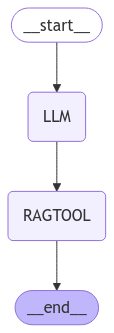

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [8]:
inputs={"message":["Tell me about llama3 model"]}

In [9]:
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("________")
        print(value)
        print("\n")

here is output from LLM
________
{'message': ['Tell me about llama3 model', '**LLaMA** is a large language model developed by Meta AI. It is designed to understand and generate human-like text, translate languages, write different kinds of creative content, and answer complex questions.']}


here is output from RAGTOOL
________
- Llama 3 is a large language model developed by Meta AI.
- It has been compared favorably against other large language models, such as GPT-3 and Claude, in most benchmarks.
- The 8B parameter version of Llama 3 has been described as being "surprisingly capable" given its size.




In [10]:
loader=DirectoryLoader("./Data_1",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_strings=[doc.page_content for doc in new_docs]

db=FAISS.from_documents(new_docs,embeddings)
reteriver=db.as_retriever(search_kwargs={"k":3})

query="Tell about the industrail growth ?"
docs=reteriver.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'Data_1\\indian_economy.txt'}
Key Sector Performances:
page_content='Key Sector Performances:' metadata={'source': 'Data_1\\indian_economy.txt'}
page_content='Additional Economic Indicators:' metadata={'source': 'Data_1\\indian_economy.txt'}
page_content='This expanded dataset provides deeper insights into the industrial revival, key growth sectors,' metadata={'source': 'Data_1\\indian_economy.txt'}


In [11]:
from typing import TypedDict,Annotated,Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

`TypedDict:`
- TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type. It’s useful when you want to enforce type checks on the keys and values of a dictionary.

`Annotated:`
- Annotated is used to add metadata or constraints to a type. It’s typically used for adding additional information, like constraints or descriptions, to the type.

`Sequence[BaseMessage]:`
- Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

`BaseMessage:`
- Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

`operator.add:`
- operator.add is a function from Python’s operator module that performs addition (+) on its arguments. In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

`TopicSelectionParser:` A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.

`Field:` Adds metadata, like descriptions, and can also be used for validation and constraints.

`Pydantic’s Role:` Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

In [12]:
class AgentState(TypedDict):
    # The 'messages' field should be  a sequence of strings and we annotate it with 'operate.add'
    # This implies we might want to "add" new messages to the sequence later
    messages:Annotated[Sequence[BaseMessage],operator.add]

`Putting It All Together:`
- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

- Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

`messages: Annotated[Sequence[BaseMessage], operator.add]`
`


`"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]`

In [13]:
from pydantic import BaseModel,Field
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="Selected Topic")
    Reasoning:str=Field(description="Reasoning behind topic selections")

In [14]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)



Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selections", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```

In [31]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selections", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [15]:
def function_1(state):
    message=state['messages']
    question=message[-1]
    print(question)

    template="""
    Your task is to classify the given query into one of the following categories:[India,Not Related].
    Only respond with the category name and nothing else.

    user_query: {question}
    {format_instructions}
            """
    prompt=PromptTemplate(template=template,
                          input_variables=[question],
                          partial_variables={"format_instructions":parser.get_format_instructions()}
                          )
    chain=prompt|llm|parser

    response=chain.invoke({"question":question,"format_instructions":parser.get_format_instructions()})

    print(response)

    return {"messages":[response.Topic]}

In [32]:
state={"messages":["Tell me about India's Industrail Growth?"]}

In [33]:
function_1(state)

Tell me about India's Industrail Growth?
Topic='India' Reasoning="The query asks about India's industrial growth, which is related to India."


{'messages': ['India']}

In [16]:
def router(state):
    print("--> Router -->")

    messages=state["messages"]
    last_messages=messages[-1]
    print(last_messages)
    if "India" in last_messages:
        return "RAG CALL"
    else:
        return "LLM CALL"

In [17]:
def function_2(state):
    print("-->CALLING RAG -->")
    message=state['messages']
    ## FETCHING THE USER QUESTIONS
    question=message[0]
    print(question)
    
    template="""Answer the question based only on the follwing context:
    {context} 
    Question:{question}
    """

    prompt=ChatPromptTemplate.from_template(template)

    print(prompt)

    retrieval_chain=({"context":reteriver,"question":RunnablePassthrough()}
                     |prompt
                     |llm
                     |StrOutputParser())
    result=retrieval_chain.invoke(question)
    return {"messages":[result]}


In [18]:
def function_3(state):
    print("--> CALLING LLM -->")

    message=state['messages']
    question=message[0] ## FETCHING THE USER QUESTION

    # NORMAL LLM CALL
    complete_query="Answer the follow question with your knowledge of the real world.Following is the user question:"+question
    response = llm.invoke(complete_query)
    return {"messages":[response.content]}

In [19]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState) ## StateGraph with Agentstate
workflow.add_node("agent",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.set_entry_point('agent')
workflow.add_conditional_edges(
    "agent",
    router,
    {
        "RAG CALL":"RAG",
        "LLM CALL":"LLM",
    }
)
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
app=workflow.compile()

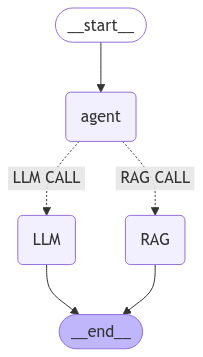

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [21]:
inputs={"messages":["Tell me about India's Industrail Growth ?"]}

In [22]:
output=app.invoke(inputs)

Tell me about India's Industrail Growth ?
Topic='India' Reasoning="The query is directly related to India's Industrial Growth"
--> Router -->
India
-->CALLING RAG -->
Tell me about India's Industrail Growth ?
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the follwing context:\n    {context} \n    Question:{question}\n    '), additional_kwargs={})]


In [23]:
output

{'messages': ["Tell me about India's Industrail Growth ?",
  'India',
  "According to the provided context, India's industrial growth has outpaced expectations, raising hopes that the economy will avoid a slowdown."]}

In [ ]:
inputs={"messages":["Tell me about first prime minister of india ?"]}

In [25]:
output=app.invoke(inputs)

Tell me about first prime mininster of india ?
Topic='India' Reasoning='The query asks about the first prime minister of India.'
--> Router -->
India
-->CALLING RAG -->
Tell me about first prime mininster of india ?
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the follwing context:\n    {context} \n    Question:{question}\n    '), additional_kwargs={})]


In [26]:
inputs={"messages":["Who building the Taj Mahal?"]}

In [27]:
output=app.invoke(inputs)
output

Who building the Taj Mahal?
Topic='India' Reasoning='The Taj Mahal is a famous historical monument located in India'
--> Router -->
India
-->CALLING RAG -->
Who building the Taj Mahal?
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the follwing context:\n    {context} \n    Question:{question}\n    '), additional_kwargs={})]


{'messages': ['Who building the Taj Mahal?',
  'India',
  'The provided context does not mention anything about who built the Taj Mahal, so I cannot answer this question from the provided context.']}

In [28]:
inputs={"messages":["Who is president of US?"]}

In [29]:
output=app.invoke(inputs)


Who is president of US?
Topic='Not Related' Reasoning='The query is about the president of the US, which is not related to India.'
--> Router -->
Not Related
--> CALLING LLM -->


In [30]:
output

{'messages': ['Who is president of US?', 'Not Related', 'Joe Biden']}